# Algorithms for Automatic Microplans Detection on Video

Арихитектура общей модели

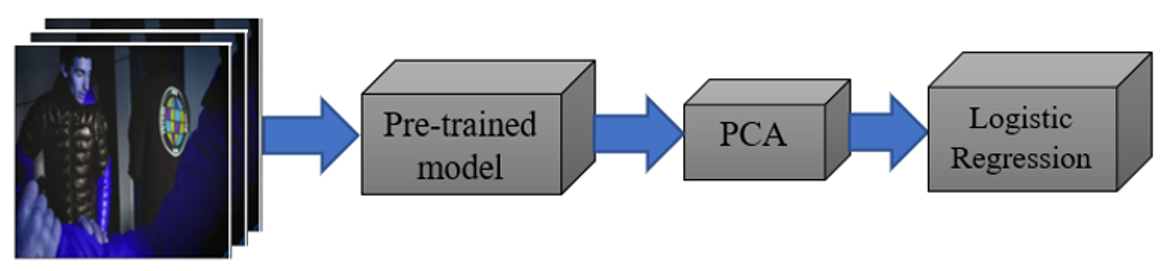

In [8]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', size=15) 
plt.rcParams['figure.figsize'] = (9,5.5)

from tqdm import tqdm_notebook
import cv2
import os


Основные функции для удобной работы

In [421]:
def read_video(file_name, dir_name = 'examples'):
    """read video, return np.array"""
    file_path = os.path.join(dir_name, file_name)
    frames = []
    cap = cv2.VideoCapture(file_path)
    while cap.isOpened():
        ret, frame = cap.read()
        # if frame is read correctly ret is True
        if not ret:
            print("Can't receive frame (stream end?). Exiting ...")
            break
        frame = cv2.resize(frame, (224,224))
        frames.append(frame)
        if cv2.waitKey(1) == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()
    return np.array(frames)

def get_labels(file_name):
    """get microplane frame numbers (index)"""
    file_name = '.'.join(file_name.split('.')[:-1])
    features = pd.read_csv('features1_.csv')
    microplan_index = features.loc[features['file_name']==file_name, 'cur_frame'].values
    return microplan_index

def read_video_and_labels(file_name, dir_name):
    """return video in array and labels (1 microplane, 0 regular frame)    
    """
    try: 
        frames = read_video(file_name, VIDEOS_DIR )
        if frames.shape[0]:
            microplane_index = get_labels(file_name)
            labels = np.zeros(frames.shape[0])
            for i in microplane_index:
                labels[i] = 1
        else:
            print('файл видео не найден...')
            return None,None
    except:
        return None, None
    return frames, labels
def get_embeddings(data, model):
    """model: словарь с ключами MobileNet и EfficientNetB7. Значение каждого ключа
    словарь, который содержит 2 ключи (net_model- для обработки входного изображения и model)
    data: входные данные (n, w,h,chanels)
    
    return: np.array() ембеддинги данных по заданной модели
    """
    x = model['net_model'].preprocess_input(data)
    embedds = model['model'].predict(x)
    return embedds
def plot_frames(frames, index_list):    
    n_rows = int(np.ceil(len(index_list)/5))
    fig, ax = plt.subplots(n_rows, 5,figsize=(14,9))
#     for i in range(len(index_list)):
    for i, a in enumerate(ax.ravel()):
#         a = ax.ravel()[i]
        if i >=len(index_list):
            a.set_axis_off()
        else:
            a.imshow(frames[index_list[i]])
            a.set_title(f'frame {index_list[i]}')
            a.set_xticks([])
            a.set_yticks([])
    plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=6, 
                    hspace=0.1,)
    fig.tight_layout(pad=0) 

Получим кадры из видео, в выборку для каждого микнроплана берем предыдущие 3 соседние кадры и также 100 случайных кадров из видео для проведения исследований

In [5]:
%%time 
VIDEOS_DIR = 'examples'
df = pd.read_csv('features1_.csv')
df.insert(3,'prev_frame3',df['cur_frame'].map(lambda x: x-3))
df.insert(3,'prev_frame2',df['cur_frame'].map(lambda x: x-2))
df.insert(3,'prev_frame1',df['cur_frame'].map(lambda x: x-1))

file_name = 'micro_1black_The North Face.webm__8011.avi'
file_name = '3 Funny Thai Advertisements - YouTube.mkv'
file_name = 'Total Recall (2012) - Elevator Explosion Scene (710) Moviecl.mp4'
label = []
all_data = []
for file_name in ['micro_1black_The North Face.webm__8011.avi',
                  '3 Funny Thai Advertisements - YouTube.mkv',
                  'Total Recall (2012) - Elevator Explosion Scene (710) Moviecl.mp4',
                  "Behind the scenes of the world's fastest__EXP.mp4",
                  "micro_2identical_Sevana - Bit Too Shy - YouTube.webm__4511.avi"
                 ]:
    print('start read video...')
    frames, labels = read_video_and_labels(file_name, VIDEOS_DIR)
    file_name = '.'.join(file_name.split('.')[:-1])
    d = df.loc[df['file_name']==file_name].copy()
    microplane_ind = set(d['cur_frame'].values)
    prev_inds = set(pd.concat([d['prev_frame1'],d['prev_frame2'], d['prev_frame3']],axis=0).values)
    prev_inds = prev_inds.difference(microplane_ind)
    random_inds = set(np.random.randint(0,frames.shape[0],100))
    prev_inds = prev_inds.union(random_inds)
    
    microplane_frames  = np.array([frames[i] for i in microplane_ind]).copy()
    
    label.extend([1 for i in range(microplane_frames.shape[0])])
    no_microplane_frames  = np.array([frames[i] for i in prev_inds]).copy()
    label.extend([0 for i in range(no_microplane_frames.shape[0])])
    all_data.append(microplane_frames)
    all_data.append(no_microplane_frames)
all_data = np.concatenate(all_data)


start read video...
Can't receive frame (stream end?). Exiting ...
start read video...
Can't receive frame (stream end?). Exiting ...
start read video...
Can't receive frame (stream end?). Exiting ...
start read video...
Can't receive frame (stream end?). Exiting ...
start read video...
Can't receive frame (stream end?). Exiting ...
Wall time: 5min 48s


Загрузим предварительно обученные модели EfficientNetB7 и MobileNet (в исследованиях используется MobileNet)

In [7]:
%%time
from tensorflow.keras.applications import mobilenet, efficientnet
INPUT_SHAPE = 224
MODELS  = {'EfficientNetB7':{}, 'MobileNet':{}}

print('load efficientnet...')
net_model=efficientnet
net_model_class=net_model.EfficientNetB7
model = net_model_class(weights='imagenet',input_shape=(INPUT_SHAPE,INPUT_SHAPE,3),include_top=False, pooling='avg')
MODELS['EfficientNetB7']['model'] = model
MODELS['EfficientNetB7']['net_model'] = net_model

print('load mobilenet...')
net_model=mobilenet
net_model_class=net_model.MobileNet
model = net_model_class(weights='imagenet',input_shape=(INPUT_SHAPE,INPUT_SHAPE,3),include_top=False, pooling='avg')
MODELS['MobileNet']['model'] = model
MODELS['MobileNet']['net_model'] = net_model

load efficientnet...
load mobilenet...
Wall time: 16.9 s


Получим эмбеддинги кадров и разделим на обучающую и тестовую выборки

In [406]:
%%time
embed = get_embeddings(all_data,MODELS['MobileNet'])
# control_embed = get_embeddings(control_frames,MODELS['MobileNet'])
trainx,testx,trainy,testy = train_test_split(embed, label,
                                             test_size = 0.25,random_state=2,                                         
                                            )

Wall time: 13.4 s


Построим расспределения классов для обоих выборок

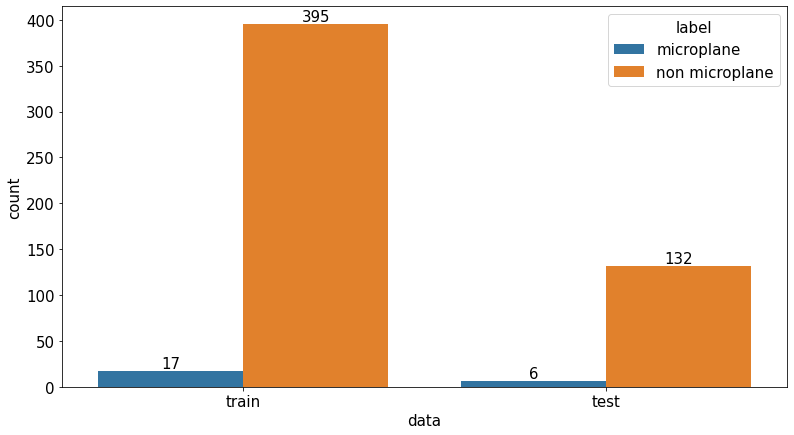

In [101]:
import seaborn as sns
temp1 = pd.DataFrame({'label':trainy, 'data':['train' for i in range(len(trainy))]})
temp2 = pd.DataFrame({'label':testy, 'data':['test' for i in range(len(testy))]})
df_plot = pd.concat([temp1, temp2],axis=0, ignore_index=True)
df_plot['label'] = df_plot['label'].replace({0:'non microplane', 1:'microplane'})

plt.figure(figsize=(13,7))
ax = sns.countplot(x = 'data', data=df_plot, hue='label')
for container in ax.containers:
    ax.bar_label(container)
# plt.grid(which='both')

Уменьшим размерности эмбеддингов с помощью PCA

Wall time: 17 ms


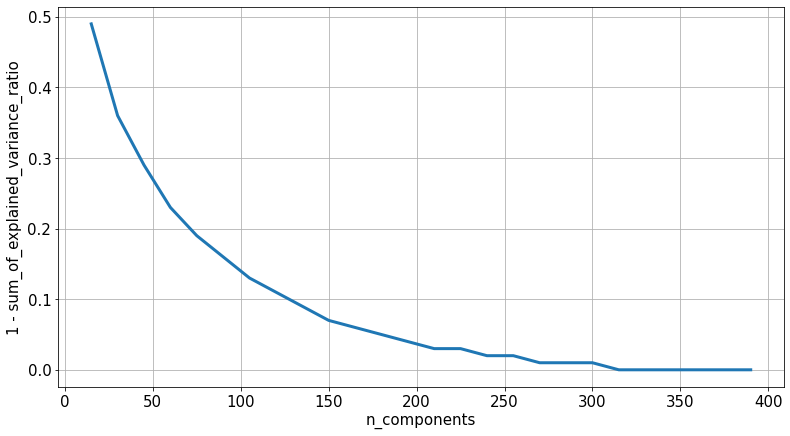

In [109]:
%%time
plt.figure(figsize=(13,7))
comp_res = {'n_components':[], 'sum_of_explained_variance_ratio':[]}
for n in range(15,405,15):
    pca = PCA(n_components = n)
    pca.fit(trainx)
    explained_variance_ratio = round(pca.explained_variance_ratio_.sum(),2)
    comp_res['n_components'].append(n)
    comp_res['sum_of_explained_variance_ratio'].append(explained_variance_ratio)
plt.plot(comp_res['n_components'], 1-np.array(comp_res['sum_of_explained_variance_ratio']),linewidth=3)
plt.xlabel('n_components')
plt.ylabel('1 - sum_of_explained_variance_ratio')
plt.grid()
pass

In [110]:
pd.DataFrame(comp_res)

n_components  sum_of_explained_variance_ratio
0             15                             0.51
1             30                             0.64
2             45                             0.71
3             60                             0.77
4             75                             0.81
5             90                             0.84
6            105                             0.87
7            120                             0.89
8            135                             0.91
9            150                             0.93
10           165                             0.94
11           180                             0.95
12           195                             0.96
13           210                             0.97
14           225                             0.97
15           240                             0.98
16           255                             0.98
17           270                             0.99
18           285                             0.99
19           300                             0.99
20           315                             1.00
21           330                             1.00
22           345                             1.00
23           360                             1.00
24           375                             1.00
25           390                             1.00

In [142]:
pca = PCA(210)
trainx = pca.fit_transform(trainx)
testx = pca.transform(testx)

Обучим Логистическую регрессию 

In [374]:
lr = LogisticRegression(random_state = 17836,
                        class_weight='balanced',
                        penalty ='l2', 
                        solver ='newton-cg',
                        C=.00025)
lr.fit(trainx, trainy)

C:\Users\Arman\AppData\Roaming\Python\Python38\site-packages\scipy\optimize\linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Arman\Anaconda3\envs\course_mag1\lib\site-packages\sklearn\utils\optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


LogisticRegression(C=0.00025, class_weight='balanced', random_state=17836,
                   solver='newton-cg')

Порог принятия решения зададим 0.49

In [385]:
pred_train =(lr.predict_proba(trainx )[:,1]>=0.49).astype(int)
pred_test =(lr.predict_proba(testx )[:,1]>=0.49).astype(int)

Построим матрицы сопряженоостей 

Text(0.5, 64.0, 'Predicted')

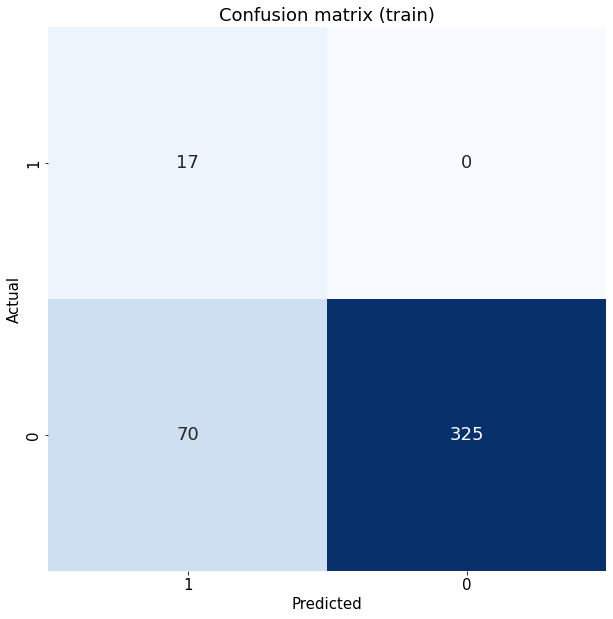

In [445]:
plt.figure(figsize=(10,10))
conf =confusion_matrix(trainy,pred_train,labels=[1,0])
sns.heatmap(conf,
            annot=True,
            cmap='Blues',
            cbar=False,
            xticklabels=['1','0'],
            yticklabels=['1','0'],
            fmt = '',
            annot_kws={"size": 18}
           )
plt.title('Confusion matrix (train)')
plt.ylabel('Actual')
plt.xlabel('Predicted')

Text(0.5, 64.0, 'Predicted')

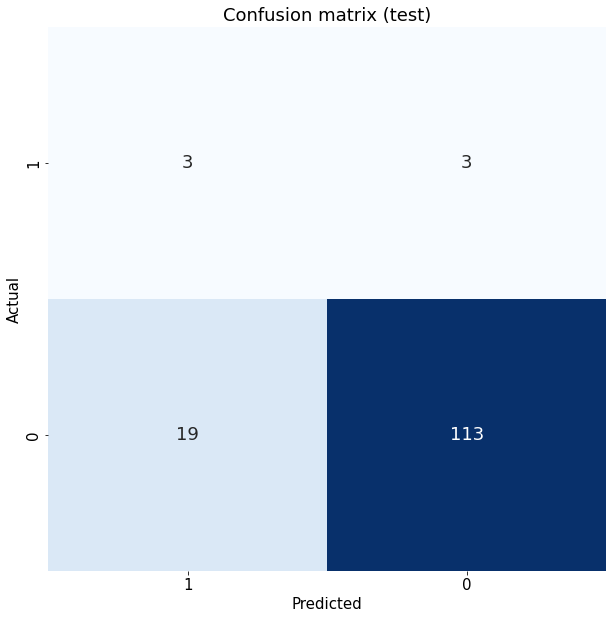

In [444]:
plt.figure(figsize=(10,10))

conf = confusion_matrix(testy,pred_test,labels=[1,0])
sns.heatmap(conf,
            annot=True,
            cmap='Blues',
            cbar=False,
            xticklabels=['1','0'],
            yticklabels=['1','0'],
            fmt = '',
            annot_kws={"size": 18}
           )
plt.title('Confusion matrix (test)')
plt.ylabel('Actual')
plt.xlabel('Predicted')

Построим ROC кривую

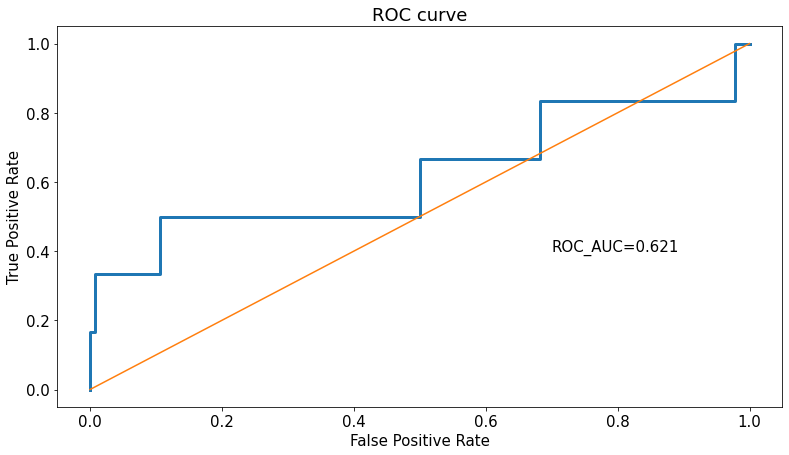

In [371]:
plt.figure(figsize=(13,7))

# predict probabilities and keep probabilities for the positive outcome only
lr_probs = lr.predict_proba(testx)[:, 1]
# calculate scores
lr_auc = roc_auc_score(testy, lr_probs)
# calculate roc curves
lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs)
# plot the roc curve for the model
plt.plot(lr_fpr, lr_tpr,linewidth=3)
plt.plot(np.arange(0,1.1,0.1), np.arange(0,1.1,0.1),)

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.text(0.7,0.4,'ROC_AUC=%.3f' % (lr_auc))


plt.show()

Так как наши данные несбалансированные, постром также Precision-Recall кривую

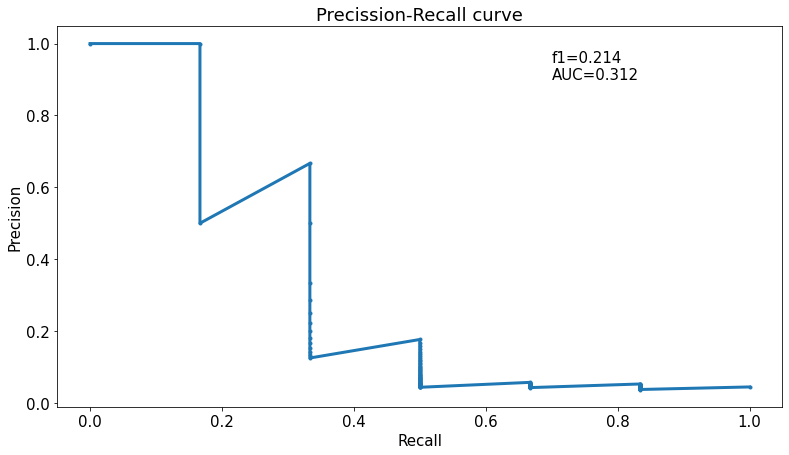

In [384]:
plt.figure(figsize=(13,7))

lr_probs = lr.predict_proba(testx)[:, 1]
lr_precision, lr_recall, _ = precision_recall_curve(testy, lr_probs)
lr_f1, lr_auc = f1_score(testy, pred_test), auc(lr_recall, lr_precision)
# plot the precision-recall curves
no_skill = len(pred_test[pred_test==1]) / len(testy)
plt.plot(lr_recall, lr_precision, marker='.',linewidth=3)
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precission-Recall curve')
plt.text(0.7,0.9,'f1=%.3f\nAUC=%.3f' % (lr_f1, lr_auc))
# show the legend
# show the plot
pyplot.show()

# PLot Frames

In [441]:
df.loc[df['file_name']=="micro_2identical_Sevana - Bit Too Shy - YouTube.webm__4511"]

video_type                                          file_name  \
795  micro_2identical  micro_2identical_Sevana - Bit Too Shy - YouTub...   
796  micro_2identical  micro_2identical_Sevana - Bit Too Shy - YouTub...   
797  micro_2identical  micro_2identical_Sevana - Bit Too Shy - YouTub...   
798  micro_2identical  micro_2identical_Sevana - Bit Too Shy - YouTub...   
799  micro_2identical  micro_2identical_Sevana - Bit Too Shy - YouTub...   

     cur_frame  prev_frame1  prev_frame2  prev_frame3  prev_frame  \
795         38           37           36           35          37   
796         67           66           65           64          66   
797         84           83           82           81          83   
798        116          115          114          113         115   
799        118          117          116          115         117   

          cur_ts      prev_ts  scene_change  ...  ahash32_dif  phash8_dif  \
795  00:00:01:14  00:00:01:13          True  ...          357          16   
796  00:00:02:19  00:00:02:18          True  ...          401          32   
797  00:00:03:12  00:00:03:11          True  ...          320          36   
798  00:00:04:20  00:00:04:19          True  ...          465          36   
799  00:00:04:22  00:00:04:21          True  ...          469          34   

     phash16_dif  phash32_dif  whash8_dif  whash16_dif  whash32_dif  \
795          102          490          18           76          338   
796          118          500          20           82          372   
797          128          532          24           98          398   
798          128          534          24           90          385   
799          130          488          24           84          379   

     colorhash3_dif  colorhash8_dif  color_shot  
795               8              30       False  
796              10              29       False  
797               4              19       False  
798               8              27       False  
799               8              30       False  

[5 rows x 25 columns]

In [430]:
file_name = 'micro_1black_The North Face.webm__8011.avi'
# file_name = '3 Funny Thai Advertisements - YouTube.mkv'
#                   'Total Recall (2012) - Elevator Explosion Scene (710) Moviecl.mp4',
#                   "Behind the scenes of the world's fastest__EXP.mp4",
#                   "micro_2identical_Sevana - Bit Too Shy - YouTube.webm__4511.avi"

# plot_frames(frames,list(range(200,210)))


Can't receive frame (stream end?). Exiting ...


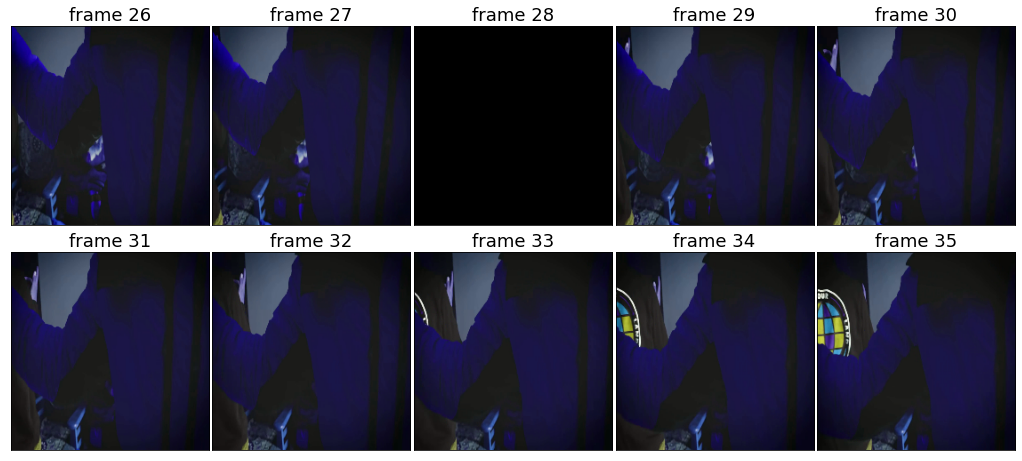

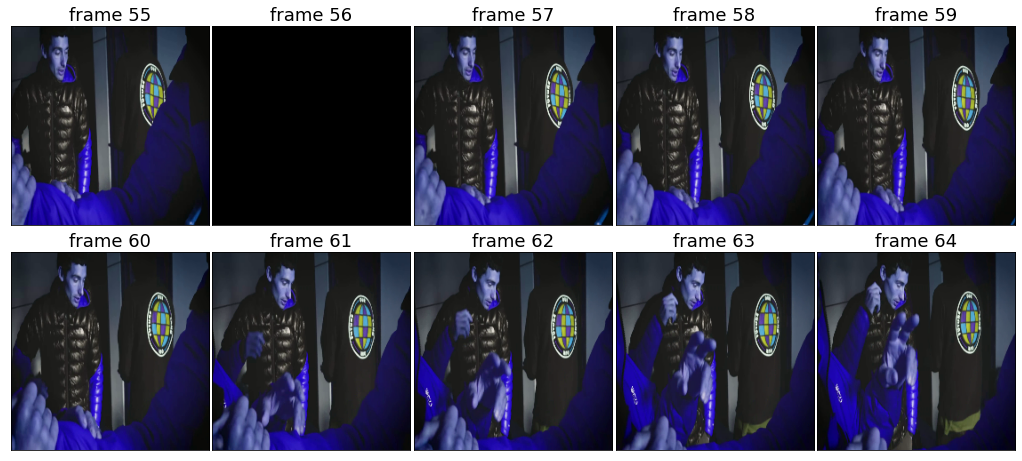

In [435]:
frames, labels = read_video_and_labels('micro_1black_The North Face.webm__8011.avi', './'+VIDEOS_DIR)
plot_frames(frames,list(range(26,36)))
plot_frames(frames,list(range(55,65)))


Can't receive frame (stream end?). Exiting ...


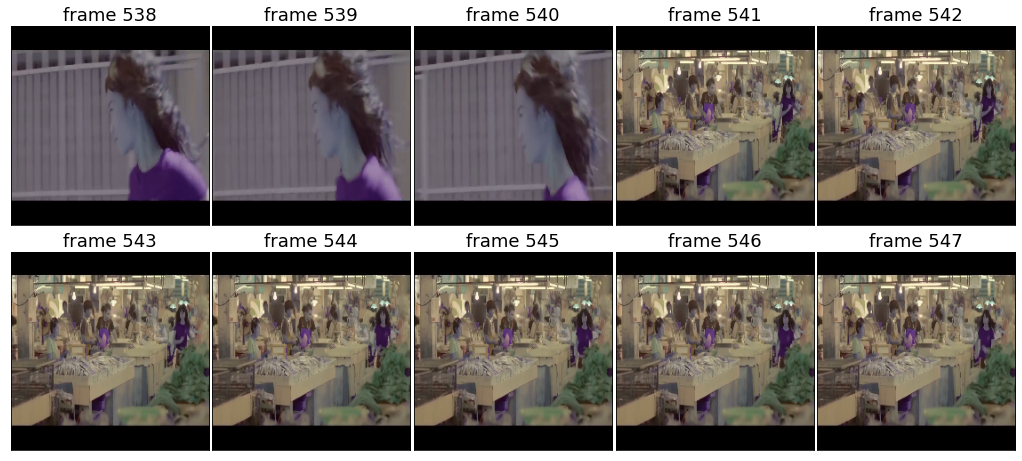

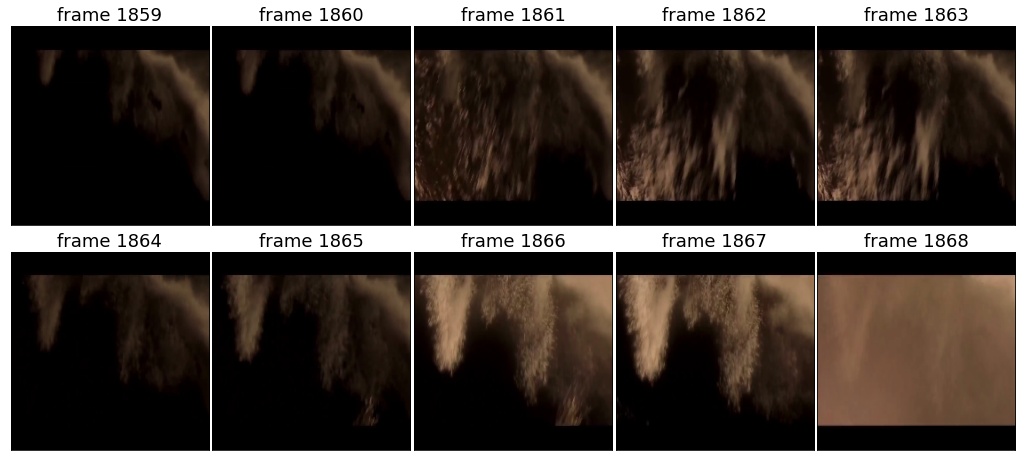

In [438]:
frames, labels = read_video_and_labels('3 Funny Thai Advertisements - YouTube.mkv', VIDEOS_DIR)
plot_frames(frames,list(range(538,548)))
plot_frames(frames,list(range(1859,1869)))

Can't receive frame (stream end?). Exiting ...


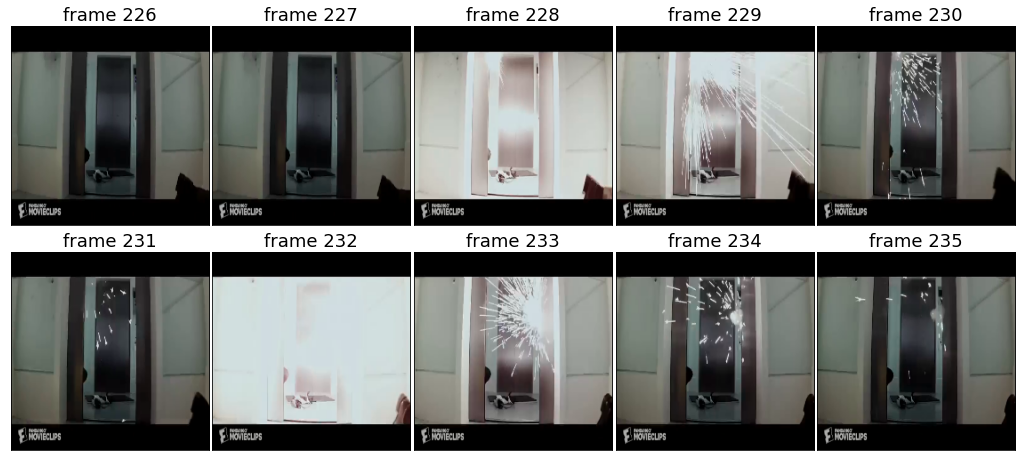

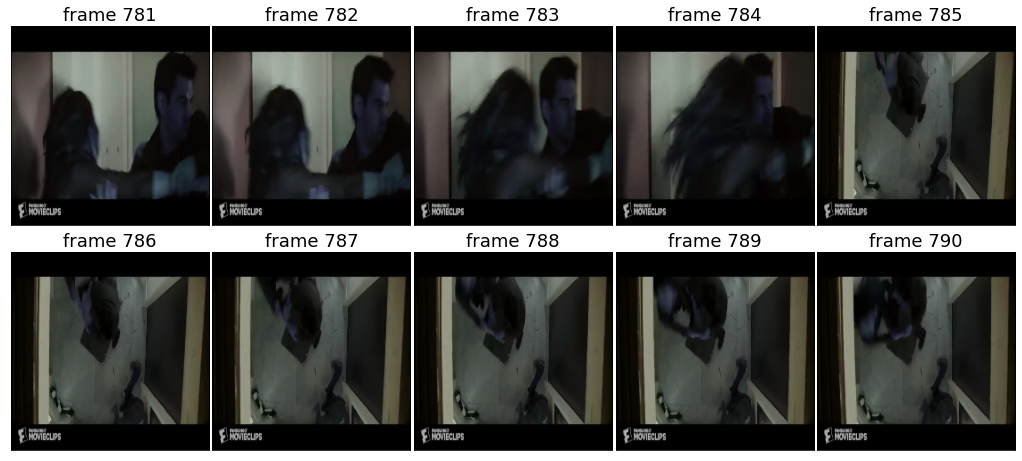

In [440]:
frames, labels = read_video_and_labels('Total Recall (2012) - Elevator Explosion Scene (710) Moviecl.mp4', VIDEOS_DIR)
plot_frames(frames,list(range(226,236)))
plot_frames(frames,list(range(781,791)))

Can't receive frame (stream end?). Exiting ...


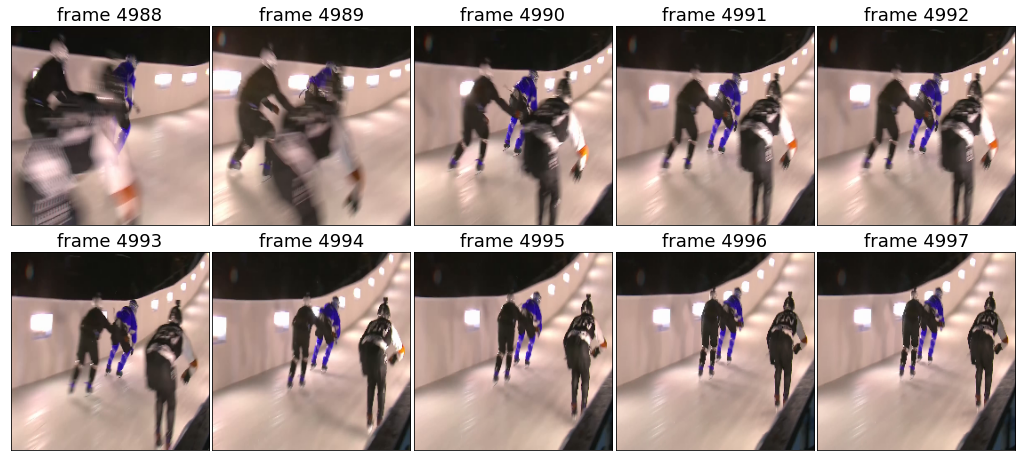

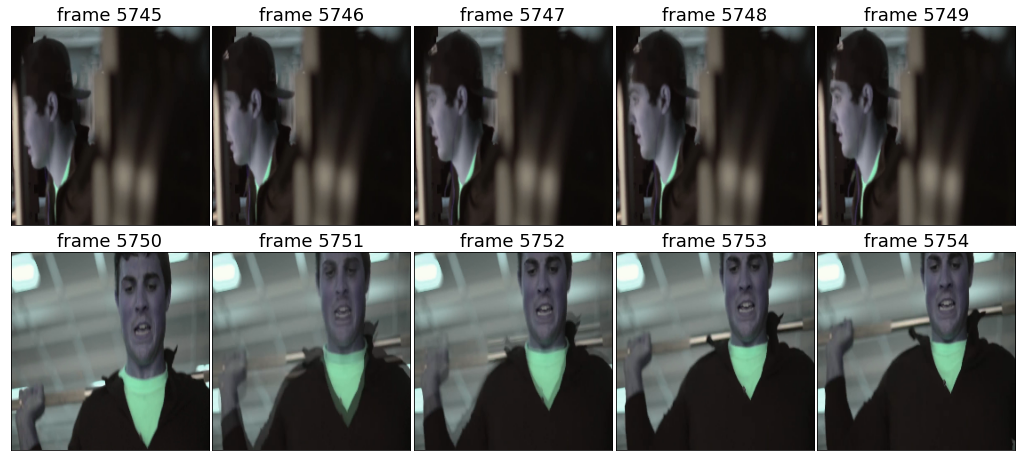

In [442]:
frames, labels = read_video_and_labels("Behind the scenes of the world's fastest__EXP.mp4", VIDEOS_DIR)
plot_frames(frames,list(range(4988,4998)))
plot_frames(frames,list(range(5745,5755)))

Can't receive frame (stream end?). Exiting ...


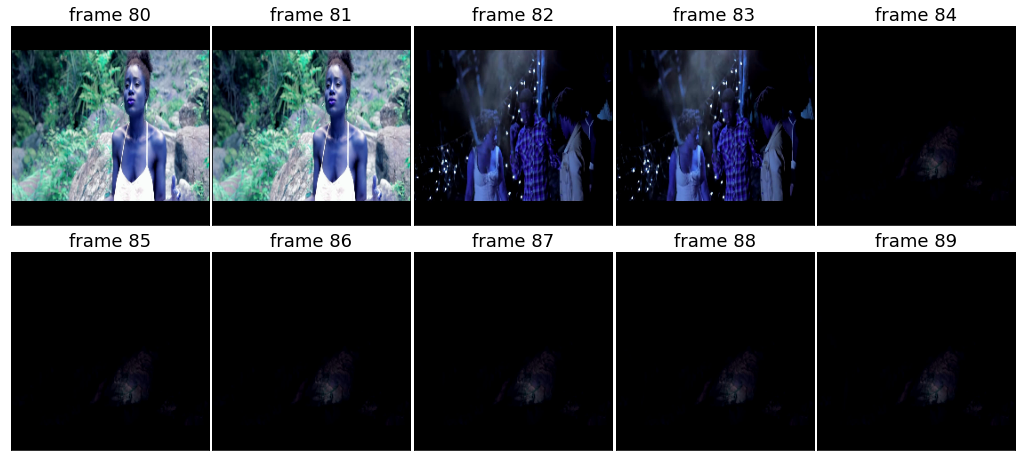

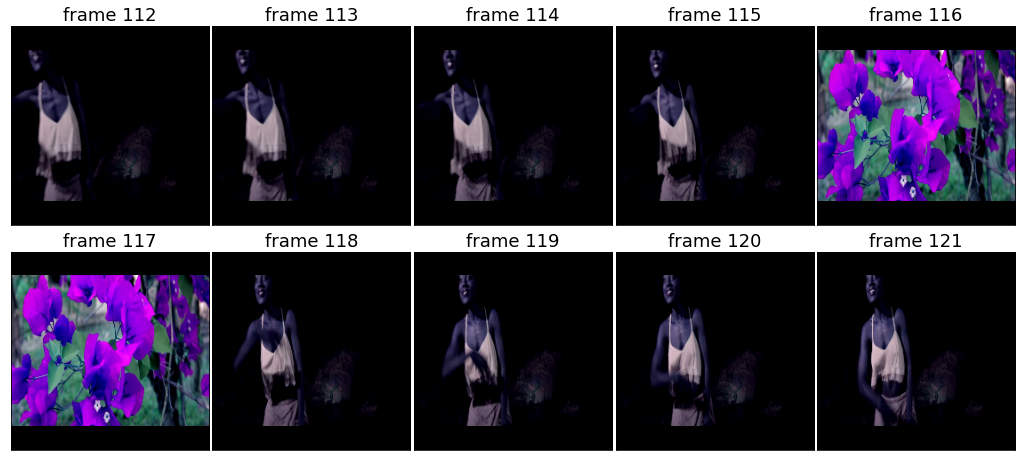

In [443]:
frames, labels = read_video_and_labels("micro_2identical_Sevana - Bit Too Shy - YouTube.webm__4511.avi", VIDEOS_DIR)
plot_frames(frames,list(range(80,90)))
plot_frames(frames,list(range(112,122)))